# Experiment with RNN

## Set paths, additional functions and import packages

**Set paths and functions**

In [1]:
root_logdir = '../Logs/'
data_dir = '../Data'
figs_dir = 'Figs/'
models_dir = '../Models/'

**Set functions**

In [2]:
# Tensorboard logs name generator
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

**Import packages**

In [3]:
import os
import time
import tensorflow as tf
import keras
from keras import models, layers
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils import shuffle
from itertools import product
from tools import *
from tensorflow.keras import datasets, layers, models, losses, Model
import pickle
from generators import *
import sys 
from numpy import reshape
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import cv2
import glob
from PIL import Image
import matplotlib.image

In [4]:
from imblearn.metrics import sensitivity_specificity_support
%matplotlib notebook

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))


Num GPUs: 1


2023-01-26 11:09:48.006609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 11:09:48.154995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 11:09:48.155225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [6]:
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

## Load data

* X = 64 BSPs
* Y = labels (0-6) (Labels 6-7 are unified)
* Y_model = identifier of the AF model (1 to 13)
* egm_tensor = tensor that stores the original EGM AF Model (1-13) for each of the BSP models (Same length has BSP S models but with 2048 nodes instead of 64)

In [7]:

n_classes = 3 #1: Rotor/no rotor ; 2: RA/LA/No rotor (2 classes) ; 3: 7 regions (3 classes) + no rotor (8 classes)

X_1channel,Y,Y_model, egm_tensor=load_data(data_type='1channelTensor', n_classes=n_classes, subsampling= True, fs_sub=50, norm=False, SR=True, SNR=20)

['LA_LIPV_150119', 'LA_LSPV_150113', 'LA_LSPV_150203', 'LA_PLAW_140612', 'LA_PLAW_140711_arm', 'LA_RIPV_150121', 'LA_RSPV_150113', 'LA_RSPV_CAF_150115', 'RA_RAA_141216', 'RA_RAA_141230', 'RA_RAFW_140807', 'RA_RAFW_SAF_140730', 'Sinusal_150629', 'TwoRotors_181219']


In [8]:
print(X_1channel.shape)
print(Y.shape)
print(Y_model.shape)

(29000, 6, 16)
(29000,)
(29000,)


In [9]:
# EGM RESAMPLE -> CONSTELLATION

constellation=False
if constellation: 
    import scipy.io
    constellation_nodes = scipy.io.loadmat('Constellation_nodes.mat')['constellation_nodes']
    constellation_nodes=np.unique(constellation_nodes)
    constellation_nodes_adjusted= [x-1 for x in constellation_nodes] #Restar 1 para ajustar índices matlab-python
    egm_tensor_resampled= egm_tensor[:,constellation_nodes_adjusted]
    print(egm_tensor_resampled.shape)


In [10]:
# Train/Test/Val Split 
'''
We split the signals so that AF Models are not mixed --> avoid leaking 

1-8 AF Models --> Train
9-11 AF Models --> Test
12-13 AF Models --> Val
'''
x_train=X_1channel[np.where((Y_model>=1) & (Y_model<=80))]
x_test=X_1channel[np.where((Y_model>80) & (Y_model<=110))]
x_val=X_1channel[np.where((Y_model>110) & (Y_model<=130))]

print('TRAIN SHAPE:',  x_train.shape )
print('TEST SHAPE:', x_test.shape )
print('VAL SHAPE:', x_val.shape )

TRAIN SHAPE: (17500, 6, 16)
TEST SHAPE: (6500, 6, 16)
VAL SHAPE: (5000, 6, 16)


# 1. PLOTTING X MATRIX

In [11]:
# Functions to plot tensors in frames

def define_image(time_instant, Tensor):
    image=Tensor[time_instant,: ,: ]
    return image
def define_frames(Tensor):
    ims = []
    for i in range(200):
        ims.append([Tensor[i, :, :]])
    return ims

## 1.1 Signal plot in random nodes of the first 10 seconds of BSPS

<IPython.core.display.Javascript object>


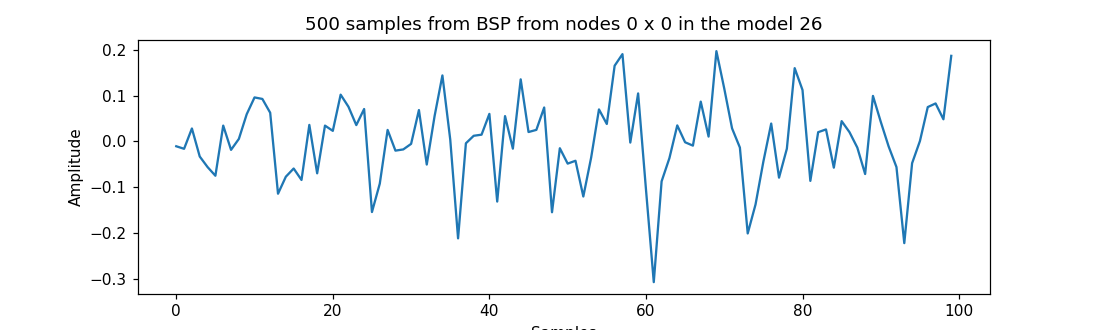

In [12]:
#Random signal visualizer: in each execution plots the first second of the BSPS in random nodes 
plt.figure(figsize=(10, 3))
a=randint(0, 5)
b=randint(0, 15)
s=randint(0, len(X_1channel)-501 )
title="500 samples from BSP from nodes {} x {} in the model {}".format(a,b,Y_model[s] )
#plt.plot(X_1channel[s:s+200, a , b])
plt.plot(X_1channel[0:100, 0 , 0])
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.title(title)
plt.show()

## 1.2 Subplot of 5 frames (images) in the range of samples r1:r2

<IPython.core.display.Javascript object>


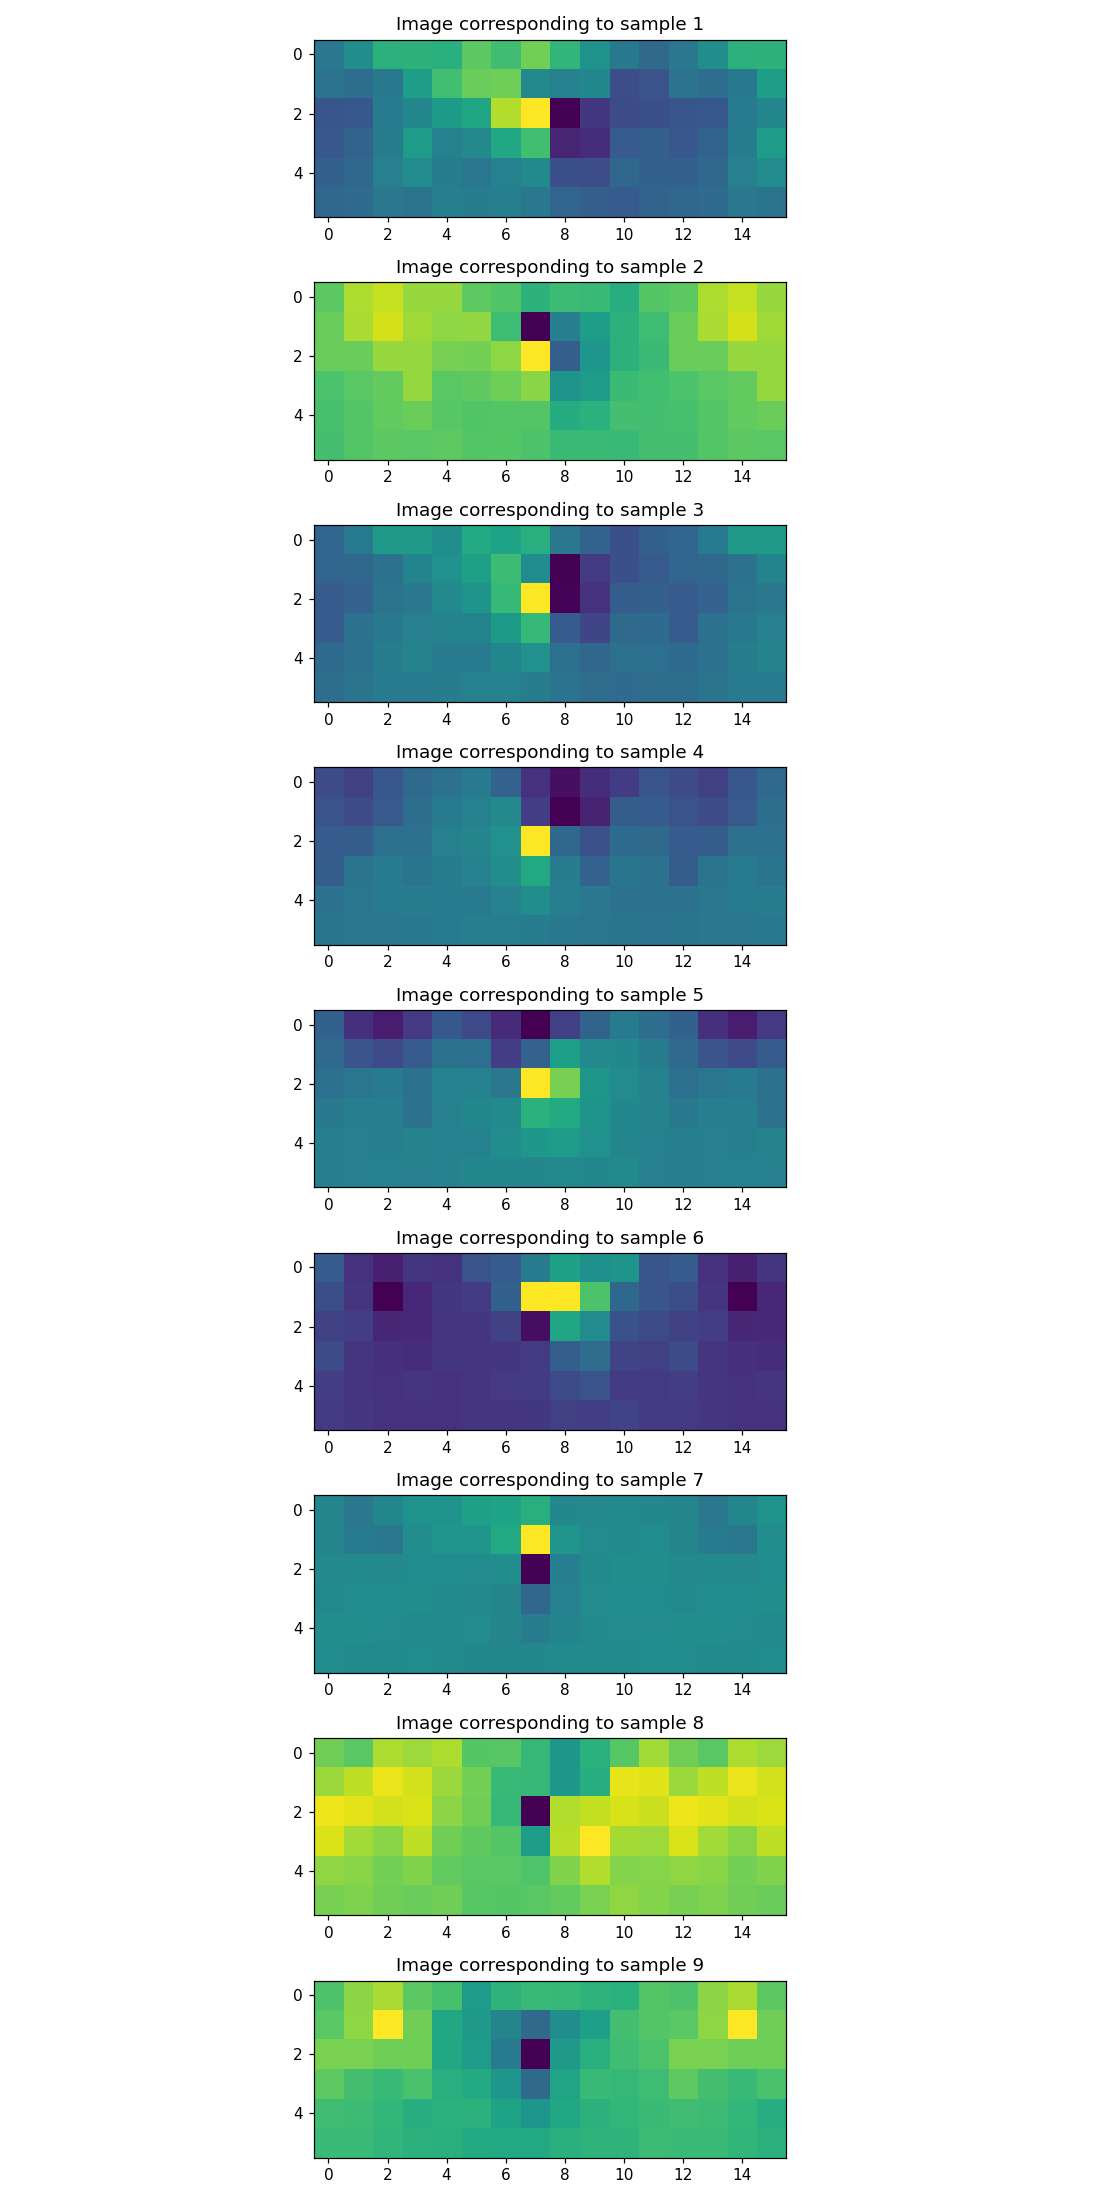

In [13]:
r1=1
r2=10

plt.figure(figsize=(10, 20), layout='tight')
for i in range(r1,r2):
    image=define_image(i, X_1channel)
    plt.subplot(r2-r1, 1, i)
    plt.imshow(image) #map='jet')
    title="Image corresponding to sample {}".format(i)
    plt.title(title)
    
plt.show()




## 1.3 PLOT INTERPOLATED IMAGES 

2023-01-26 11:12:38.387000: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-26 11:12:38.388045: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 11:12:38.388496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 11:12:38.388797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

<IPython.core.display.Javascript object>


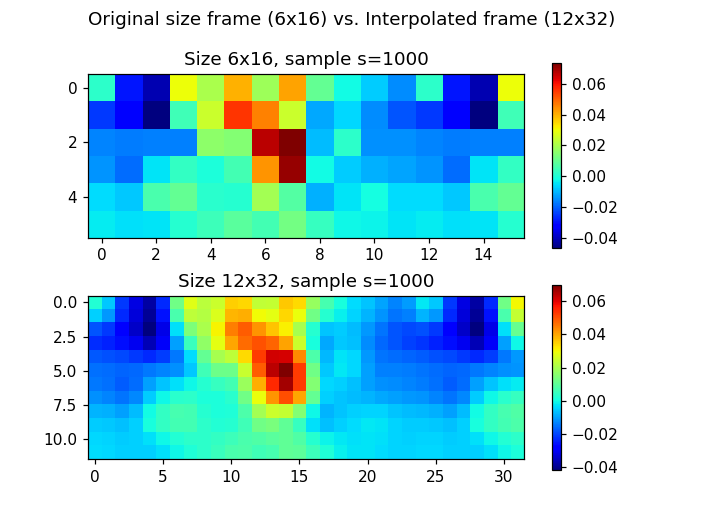

In [14]:


'''
#Divide train, val and test
x_train= X_1channel[0:int(len(X_1channel)*0.7), :]
x_test= X_1channel[int(len(X_1channel)*0.7)+1:int(len(X_1channel)*0.7)+1+int(len(X_1channel)*0.25), :, :]
x_val= X_1channel[int(len(X_1channel)*0.7)+1+int(len(X_1channel)*0.25):-1, :, :]
x_train_or, x_test_or, x_val_or=x_train, x_test, x_val
'''

'''
#Standardization
scalers = {}
for i in range(x_train.shape[1]):
    scalers[i] = StandardScaler()
    x_train[:, i, :] = scalers[i].fit_transform(x_train[:, i, :]) 

for i in range(x_test.shape[1]):
    x_test[:, i, :] = scalers[i].transform(x_test[:, i, :]) 
    
for i in range(x_val.shape[1]):
    x_val[:, i, :] = scalers[i].transform(x_val[:, i, :]) 
x_train_st=x_train


#Standardization
scalers = {}
for i in range(y_train.shape[1]):
    scalers[i] = StandardScaler()
    y_train[:, i, :] = scalers[i].fit_transform(y_train[:, i, :]) 

for i in range(y_test.shape[1]):
    y_test[:, i, :] = scalers[i].transform(y_test[:, i, :]) 
    
for i in range(x_val.shape[1]):
    y_val[:, i, :] = scalers[i].transform(y_val[:, i, :]) 
x_train_st=x_train
'''

F= 1000

x_train_or, x_test_or, x_val_or=x_train, x_test, x_val

#Reshape for interpolation
x_train = reshape(x_train, (len(x_train), 6, 16,1)) 
x_test = reshape(x_test, (len(x_test), 6, 16,1))
x_val = reshape(x_val, (len(x_val), 6, 16,1))

#Interpolation
x_train = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x_train)
x_test = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x_test)
x_val = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x_val)

#Plot
plt.figure()
plt.subplot(2,1,1)
image=define_image(F,x_train_or)
plt.imshow(image, cmap='jet')
plt.title('Size 6x16, sample s={}'. format(F))
plt.colorbar()

plt.subplot(2,1,2)
image=define_image(F,x_train )
plt.imshow(image, cmap='jet')
plt.title('Size 12x32, sample s={}'. format(F))
plt.colorbar()
plt.suptitle('Original size frame (6x16) vs. Interpolated frame (12x32)'  )


plt.show()

# Autoencoder model

In [15]:
encoder = models.Sequential()
encoder.add(layers.Conv2D(32, (2, 2), strides=1, padding='same', activation='relu', input_shape=x_train.shape[1:]))
encoder.add(layers.MaxPooling2D((2, 2)))
encoder.add(layers.Dropout(0.2))
encoder.add(layers.Conv2D(12, (2, 2), strides=1, padding='same', activation='relu'))
encoder.add(layers.MaxPooling2D((2, 2)))
encoder.add(layers.Conv2D(12, (2, 2), strides=1, padding='same', activation='linear'))
encoder.add(layers.MaxPooling2D((1, 2)))

encoder.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 12, 32, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 16, 32)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 6, 16, 32)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 16, 12)         1548      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 8, 12)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 8, 12)          5

In [16]:
decoder = models.Sequential()
decoder.add(layers.Conv2D(12, (2,2), strides=1, padding='same', activation='relu', input_shape=encoder.output.shape[1:]))
decoder.add(layers.UpSampling2D((1, 2)))
decoder.add(layers.Conv2D(12, (2,2), strides=1, padding='same', activation='relu'))
decoder.add(layers.UpSampling2D((2, 2)))
decoder.add(layers.Dropout(0.2))
decoder.add(layers.Conv2D(32, (2,2), strides=1, padding='same', activation='relu'))
decoder.add(layers.UpSampling2D((2, 2)))
decoder.add(layers.Conv2D(1, (2,2), strides=1, padding='same', activation='linear'))
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 3, 4, 12)          588       
                                                                 
 up_sampling2d_3 (UpSampling  (None, 3, 8, 12)         0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 3, 8, 12)          588       
                                                                 
 up_sampling2d_4 (UpSampling  (None, 6, 16, 12)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 16, 12)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 16, 32)        

In [17]:
conv_autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.outputs))
conv_autoencoder.compile(optimizer='adam', loss=losses.mean_squared_error)
history = conv_autoencoder.fit(x_train, x_train, batch_size=50, epochs=20, validation_data=(x_val, x_val))

Epoch 1/20


2023-01-26 11:12:41.929042: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2023-01-26 11:12:43.276884: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


350/350 [==============================] - 9s 10ms/step - loss: 0.0063 - val_loss: 0.0120
Epoch 2/20
350/350 [==============================] - 3s 10ms/step - loss: 0.0033 - val_loss: 0.0104
Epoch 3/20
350/350 [==============================] - 3s 9ms/step - loss: 0.0028 - val_loss: 0.0089
Epoch 4/20
350/350 [==============================] - 3s 9ms/step - loss: 0.0025 - val_loss: 0.0090
Epoch 5/20
350/350 [==============================] - 3s 9ms/step - loss: 0.0023 - val_loss: 0.0082
Epoch 6/20
350/350 [==============================] - 3s 9ms/step - loss: 0.0022 - val_loss: 0.0079
Epoch 7/20
350/350 [==============================] - 3s 9ms/step - loss: 0.0021 - val_loss: 0.0078
Epoch 8/20
350/350 [==============================] - 3s 9ms/step - loss: 0.0020 - val_loss: 0.0082
Epoch 9/20
350/350 [==============================] - 3s 9ms/step - loss: 0.0020 - val_loss: 0.0080
Epoch 10/20
350/350 [==============================] - 3s 10ms/step - loss: 0.0019 - val_loss: 0.0082
Epoch 1

In [18]:
decoded_imgs = conv_autoencoder.predict(x_test)
print(decoded_imgs.shape, x_test.shape)
decoded_imgs = reshape(decoded_imgs, (len(decoded_imgs), decoded_imgs.shape[1],  decoded_imgs.shape[2]))
x_test = reshape(x_test, (len(x_test),x_test.shape[1],  x_test.shape[2])) 
print(decoded_imgs.shape, x_test.shape)

(6500, 12, 32, 1) (6500, 12, 32, 1)
(6500, 12, 32) (6500, 12, 32)


# 2. TRAINING PLOTS

## 2.1 Learning curves

<IPython.core.display.Javascript object>


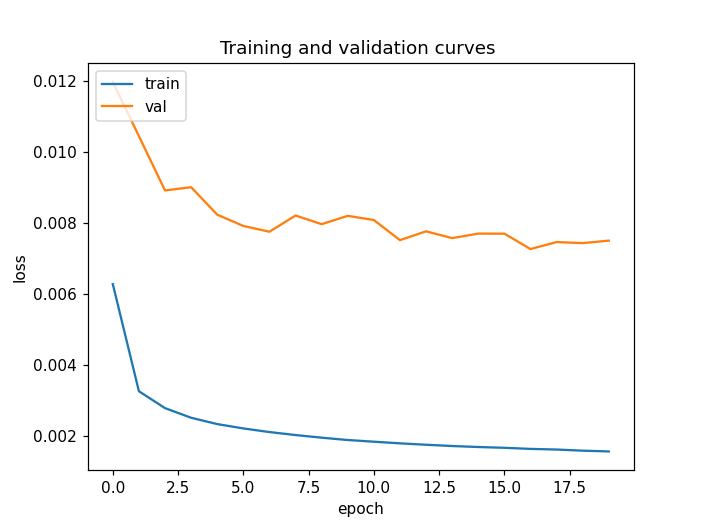

In [19]:
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and validation curves ')
plt.show()

# 3. OUTPUT PLOTS

## 3.1 Input frame vs. Output frame in time_instant

<IPython.core.display.Javascript object>


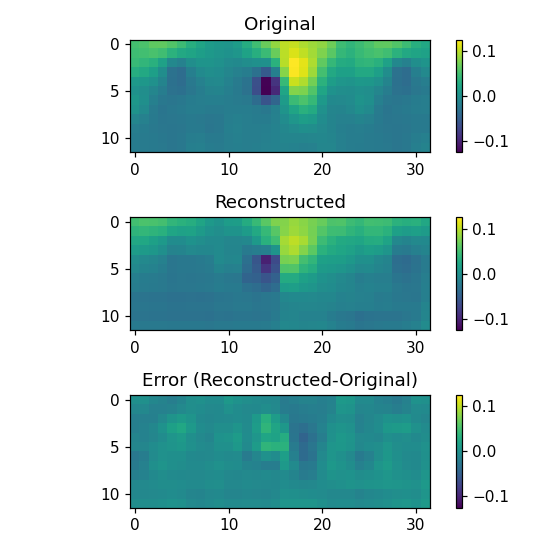

In [20]:
time_instant= 2000

plt.figure(figsize=(5,5), layout='tight')
plt.subplot(3,1,1)
image1=define_image(time_instant,x_test )
min_val, max_val = np.amin(image1), np.amax(image1)
plt.imshow(image1, vmin=min_val, vmax=max_val)#, cmap='jet')
plt.colorbar()
plt.title('Original')
plt.subplot(3,1,2)
image2=define_image(time_instant,decoded_imgs)
plt.imshow(image2, vmin=min_val, vmax=max_val) #, cmap='jet')
plt.colorbar()
plt.title('Reconstructed')
plt.subplot(3,1,3)
plt.imshow(image2-image1, vmin=min_val, vmax=max_val)
plt.title('Error (Reconstructed-Original)')
plt.colorbar()
plt.show()

## 3.2 Signal visualizer input vs output: plots signal in random nodes and compares 

<IPython.core.display.Javascript object>


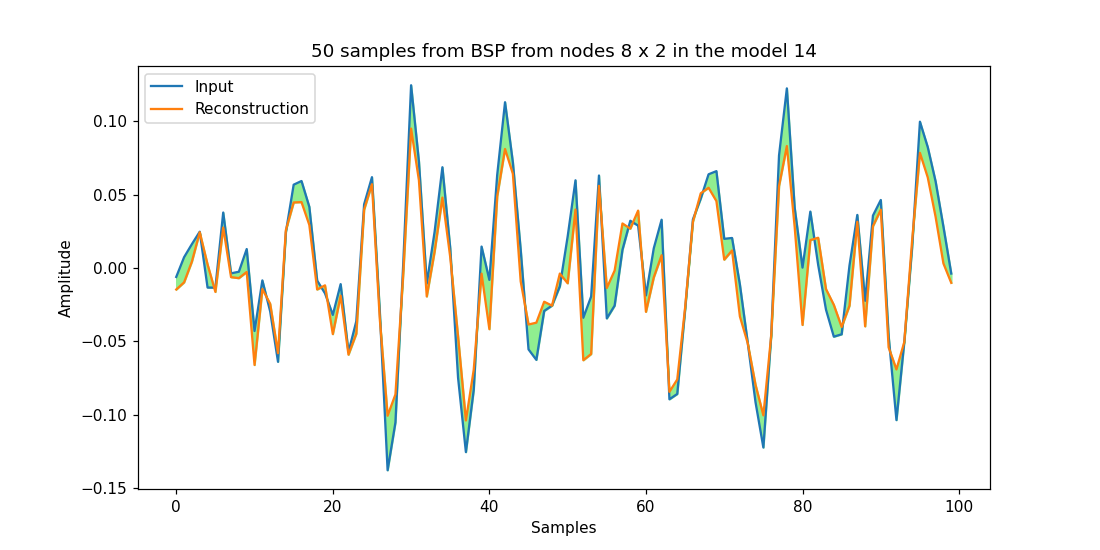

In [21]:
'''
plt.figure(figsize=(10, 5))
plt.plot(x_test[0:fs, 1, 1], label=('Input'))
plt.plot(decoded_imgs[0:fs, 1, 1], label=('Reconstruction'))
plt.fill_between(np.arange(fs), decoded_imgs[0:fs, 1, 1],x_test[0:fs, 1, 1], color='lightgreen')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()
'''
#PLOTS 50 samples --> 1 second

#Random signal visualizer: in each execution plots the first second of the BSPS in random nodes 
plt.figure(figsize=(10, 5))
a=randint(0, decoded_imgs.shape[1]-1)
b=randint(0, decoded_imgs.shape[2]-1)
s=randint(0, len(decoded_imgs)-fs-1 )
title="50 samples from BSP from nodes {} x {} in the model {}".format(a,b,Y_model[s] )
plt.plot(x_test[s:s+100, a , b], label=('Input'))
plt.plot(decoded_imgs[s:s+100, a , b], label=('Reconstruction'))
plt.fill_between(np.arange(100), decoded_imgs[s:s+100, a , b],x_test[s:s+100, a , b], color='lightgreen')
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.legend()
plt.title(title)
plt.show()

# Latent Space 

In [22]:
latent_vector = encoder.predict(x_test)
print('Latent space shape:',latent_vector.shape)
print('--> Time instants:',latent_vector.shape[0])
print('--> Height:',latent_vector.shape[1])
print('--> Width:',latent_vector.shape[2])
print('--> Number of filters:',latent_vector.shape[3])

Latent space shape: (6500, 3, 4, 12)
--> Time instants: 6500
--> Height: 3
--> Width: 4
--> Number of filters: 12


# 3.3 Plot latent space frames in random time instant 

<IPython.core.display.Javascript object>


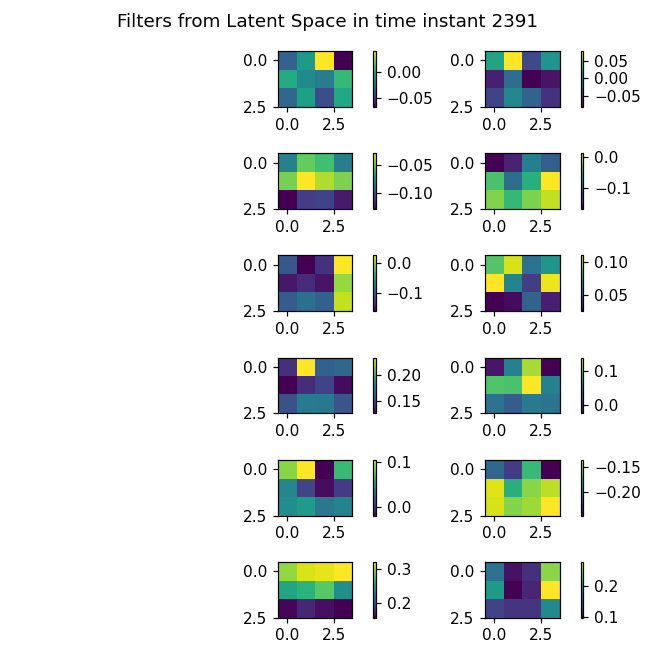

In [23]:
time_instant= randint(0, len(decoded_imgs)-fs-1 )
plt.figure(figsize=(6,6), layout='tight')
title="Filters from Latent Space in time instant {} ".format(time_instant)
for i in range (0,12):
    plt.subplot(6, 2, i+1)
    #plt.plot(6, 2, i) 
    plt.imshow(latent_vector[time_instant, :, :,i])#, cmap='jet')
    plt.colorbar()
plt.suptitle(title)

plt.show()

## 3.4 Plots latent space in signal format: 50 samples, each filter one line

<IPython.core.display.Javascript object>


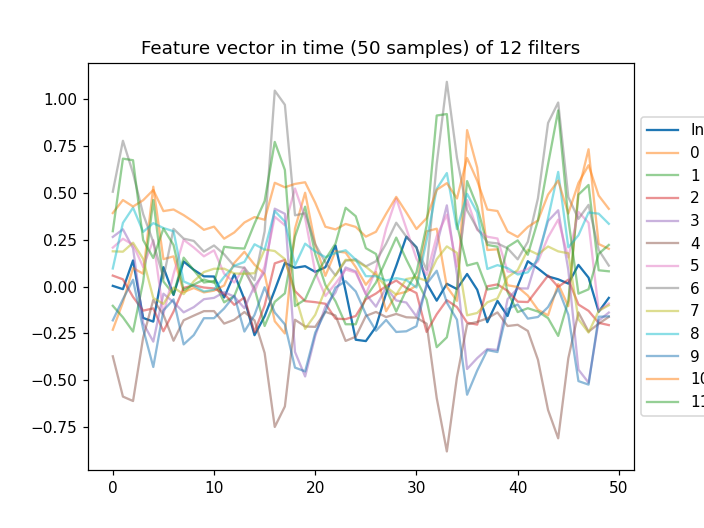

In [24]:
plt.figure()
plt.plot(x_test[0:50, 1, 1], label ='Input')#, cmap='jet')

for i in range (0,12):
    #plt.plot(6, 2, i) 
    plt.plot(latent_vector[500:550, 1, 1,i], alpha=0.5,  label=i)#, cmap='jet')
    plt.title('Feature vector in time (50 samples) of 12 filters')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## 3.5 Plot of reconstruction (orange) over the context of 14 seconds of random input signal 

700 total length [592, 692] subwindow size


<IPython.core.display.Javascript object>


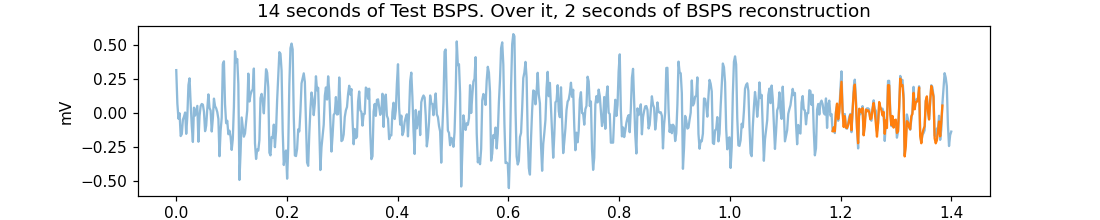

In [25]:
#PLOT INPUT VS OUTPUT
import random
window_length_test=700 #samples
window_length_subsegment=100
t_vector= np.array(np.linspace(0, window_length_test/fs, window_length_test))
t_vector_reshaped=t_vector.reshape(t_vector.shape[0], 1, 1)

#Random big window to show x_test
randomonset_test=random.randrange(len(x_test)-window_length_test)
random_window_test= [randomonset_test, randomonset_test + window_length_test]

x_test_cut=x_test[random_window_test[0]:random_window_test[1],1, 1 ]
decoded_imgs_cut=decoded_imgs[random_window_test[0]:random_window_test[1],1, 1 ]

#smaller window to show subsegment inside x_test
randomonset=random.randrange(len(x_test_cut)-window_length_subsegment)
random_window_subsegment= [randomonset, randomonset + window_length_subsegment]
print(decoded_imgs_cut.size, 'total length', random_window_subsegment, 'subwindow size')
copy_decoded_imgs_cut=decoded_imgs_cut
decoded_imgs_cut[:random_window_subsegment[0]]=None
decoded_imgs_cut[random_window_subsegment[1]:]=None

plt.figure(figsize=(10,2))
plt.plot(t_vector, x_test_cut, alpha=0.5, label=('Test'))
plt.plot(t_vector, decoded_imgs_cut, label=('Reconstruction') )
#plt.plot(t_vector, copy_decoded_imgs_cut )


plt.xlabel('Time(s)')
plt.ylabel('mV')
plt.title('14 seconds of Test BSPS. Over it, 2 seconds of BSPS reconstruction')

plt.show()

In [26]:
x_test.shape

(6500, 12, 32)

# Video generation

In [27]:
samples, height, width = x_test.shape
size = (width,height)
print(size)
FPS=5
video = False
if video:

    #Save frames as pnf into folder
    for i in range(samples):
        im = Image.fromarray(x_test[i, :, :])

        matplotlib.image.imsave('./Frames_test/frame{}.png'.format(i), im)


    #Save frames as pnf into folder
    for i in range(len(decoded_imgs)):
        im = Image.fromarray(decoded_imgs[i, :, :])

        matplotlib.image.imsave('./Frames_reconstruction/frame{}.png'.format(i), im)

    #Save frames as pnf into folder
    for i in range(len(latent_vector)):
        im = Image.fromarray(latent_vector[i, :, :, 1])

        matplotlib.image.imsave('./Frames_LS/frame{}.png'.format(i), im)

    #Load png and convert to video
    frameSize = (width,height)
    out = cv2.VideoWriter('./Videos/output_video_test_{}_fps.avi'.format(FPS),cv2.VideoWriter_fourcc(*'DIVX'), FPS, frameSize)

    for filename in glob.glob('./Frames_test/*.png'):
        img = cv2.imread(filename)
        out.write(img)

    out.release()


    samples, height, width, filters = latent_vector.shape
    frameSize = (width,height)
    out = cv2.VideoWriter('./Videos/output_LS_{}_fps.avi'.format(FPS),cv2.VideoWriter_fourcc(*'DIVX'), FPS, frameSize)

    for filename in glob.glob('./Frames_LS/*.png'):
        img = cv2.imread(filename)
        out.write(img)

    out.release()


(32, 12)


## 3.6 PSD Welch of input, output and Latent Space

<IPython.core.display.Javascript object>


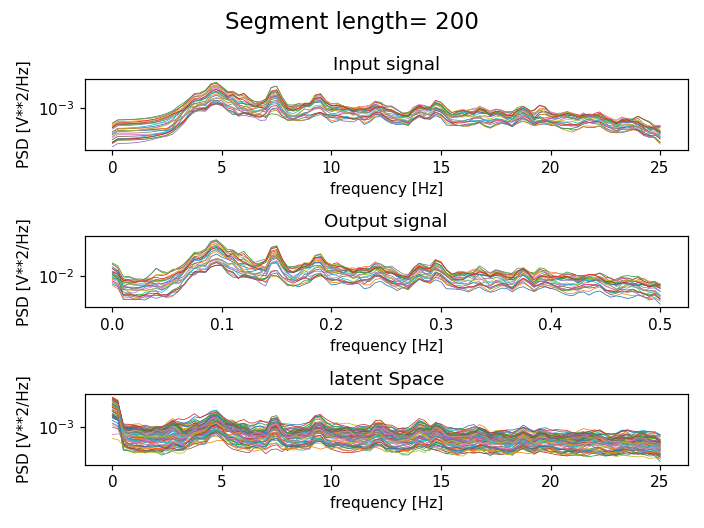

Text(0.5, 0.98, 'Segment length= 200')

In [127]:
input_signal= x_test
LS_signal= latent_vector
output_signal= decoded_imgs
nperseg_value=200

fig=plt.figure(layout='tight')

plt.subplot(3,1,1)

#Input
for height in range(0,10, 2):
    for width in range(0,10, 2):
    
        f, Pxx_den = signal.welch(input_signal[:, height,width], 50, nperseg=nperseg_value,
                                  noverlap = nperseg_value // 2, scaling = 'density', detrend=False )
        plt.semilogy(f, Pxx_den,linewidth=0.5)
        plt.xlabel('frequency [Hz]')
        plt.ylabel('PSD [V**2/Hz]')
        titlee="PSD Welch of input signal. nodes ({} , {})".format(height,width )
        plt.title('Input signal')
        plt.show()

# Output
plt.subplot(3,1,2)
for height in range(0,10, 2):
    for width in range(0,10, 2):
    
        f, Pxx_den = signal.welch(output_signal[:, height,width], nperseg=nperseg_value,
                                  noverlap = nperseg_value // 2, scaling = 'density', detrend=False )
        plt.semilogy(f, Pxx_den,linewidth=0.5)
        plt.xlabel('frequency [Hz]')
        plt.ylabel('PSD [V**2/Hz]')
        titlee="PSD Welch of output signal. nodes ({} , {})".format(height,width )
        plt.title('Output signal')
        plt.show()

# Latent Space
plt.subplot(3,1,3)
for height in range(0,3):
    for width in range(0,4):
        for filters in range(0,12,2):
    
            f, Pxx_den = signal.welch(LS_signal[:, height,width, filters], 50, nperseg=nperseg_value,
                                  noverlap = nperseg_value // 2, scaling = 'density', detrend=False )
            plt.semilogy(f, Pxx_den, linewidth=0.5)
            plt.xlabel('frequency [Hz]')
            plt.ylabel('PSD [V**2/Hz]')
            titlee="PSD Welch of Latent Space signal. nodes ( - )".format(height,width )
            plt.title('latent Space')
            plt.show()
fig.suptitle("Segment length= 200", fontsize=15)



<IPython.core.display.Javascript object>


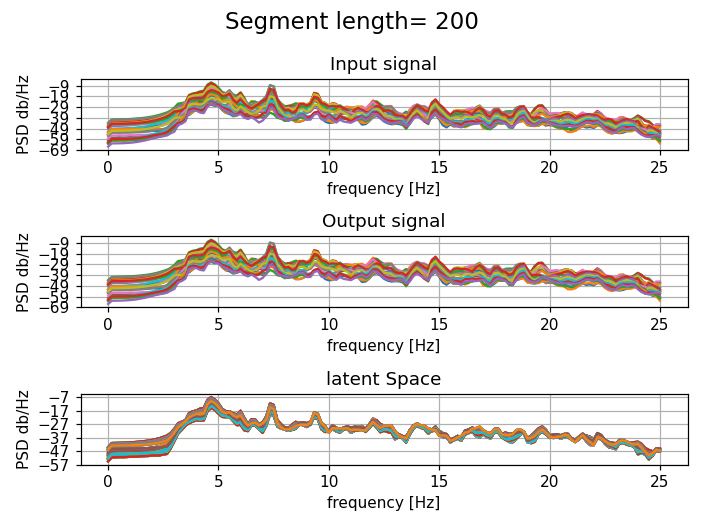

Text(0.5, 0.98, 'Segment length= 200')

In [128]:
#normalizar


#PSD 
input_signal= x_test
LS_signal= latent_vector
output_signal= decoded_imgs
nperseg_value=300

fig=plt.figure(layout='tight')

plt.subplot(3,1,1)

#Input
for height in range(0,10, 2):
    for width in range(0,10, 2):
    
        Pxx_den = plt.psd(input_signal[:, height,width],NFFT=nperseg_value, Fs=50, 
                             detrend=None, noverlap=nperseg_value // 2)
                            
        #plt.plot(f, Pxx_den,linewidth=0.5)
        plt.xlabel('frequency [Hz]')
        plt.ylabel('PSD db/Hz')
        titlee="PSD of input signal. nodes ({} , {})".format(height,width )
        plt.title('Input signal')
        plt.show()

# Output
plt.subplot(3,1,2)
for height in range(0,10, 2):
    for width in range(0,10, 2):
    
        Pxx_den = plt.psd(input_signal[:, height,width],NFFT=nperseg_value, Fs=50, 
                             detrend=None, noverlap=nperseg_value // 2)
        plt.xlabel('frequency [Hz]')
        plt.ylabel('PSD db/Hz')
        titlee="PSD of output signal. nodes ({} , {})".format(height,width )
        plt.title('Output signal')
        plt.show()

# Latent Space
plt.subplot(3,1,3)
for height in range(0,3):
    for width in range(0,4):
        for filters in range(0,12,2):
    
            Pxx_den = plt.psd(input_signal[:, height,width],NFFT=nperseg_value, Fs=50, 
                             detrend=None, noverlap=nperseg_value // 2)
        
            plt.xlabel('frequency [Hz]')
            plt.ylabel('PSD db/Hz')
            titlee="PSD Latent Space signal. nodes ( - )".format(height,width )
            plt.title('latent Space')
            plt.show()
fig.suptitle("Segment length= 200", fontsize=15)



# Estimation EGM

In [30]:
#Input --> Latent space 
latent_vector_train = encoder.predict(x_train)
latent_vector_test = encoder.predict(x_test)
latent_vector_val  = encoder.predict(x_val)

In [114]:
def normalize_array(array, high, low, axis_n=0):
    mins = np.min(array, axis=axis_n)
    maxs = np.max(array, axis=axis_n)
    rng = maxs - mins
    norm_array = high - (((high - low) * (maxs - array)) / rng)
    return norm_array

def standardize_array(array, axis_n=0):
    return (array - np.mean(array)) / np.std(array)

In [93]:
#first we merge Latent Space train/test/val
norm = True

con = np.concatenate((latent_vector_train, latent_vector_test))
latent_space = np.concatenate((con, latent_vector_val))

if norm:
    latent_space_n = []
    egm_tensor_n = []

    for model in np.unique(Y_model):

        #1. Normalize Latent space
        arr_to_norm_ls = latent_space[np.where((Y_model== model))]     #select window of signal belonging to model i
        latent_space_norm = normalize_array (arr_to_norm_ls, 1, -1) 
        latent_space_n.extend(latent_space_norm) #Add to new norm array

        #2. Normalize egm (output)

        arr_to_norm_egm = egm_tensor[np.where((Y_model== model))]     #select window of signal belonging to model i
        egm_tensor_norm = normalize_array (arr_to_norm_egm, 1, -1) 
        egm_tensor_n.extend(egm_tensor_norm) #Add to new norm array

    latent_space_n=np.array(latent_space_n)
    egm_tensor_n=np.array(egm_tensor_n)

else: 
    
    latent_space_n=latent_space
    egm_tensor_n=egm_tensor


#Split again latent_space in train/test/val 

latent_vector_train=latent_space_n[np.where((Y_model>=1) & (Y_model<=80))]
latent_vector_test=latent_space_n[np.where((Y_model>80) & (Y_model<=110))]
latent_vector_val=latent_space_n[np.where((Y_model>110) & (Y_model<=130))]


<IPython.core.display.Javascript object>


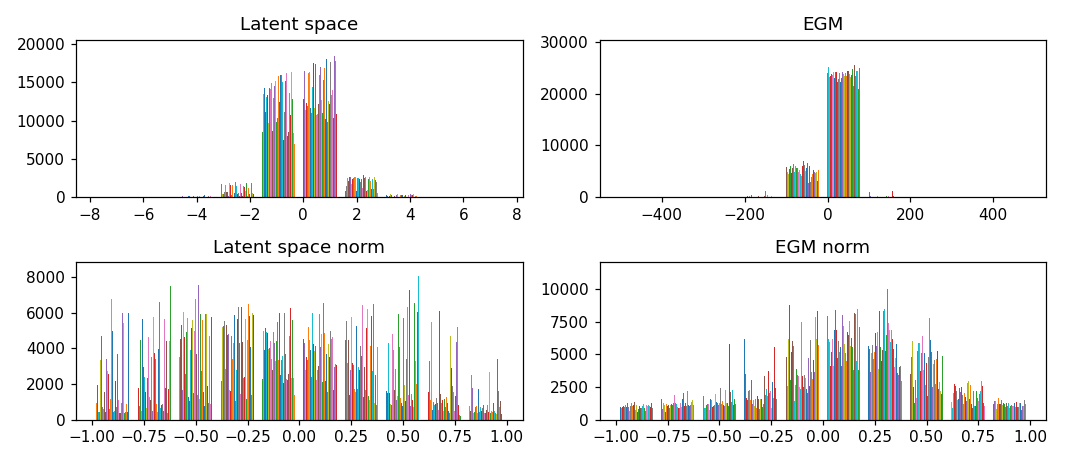

In [94]:
plt.figure(layout='tight')
plt.subplot(2,2,1)
plt.hist(np.reshape(latent_space, (latent_space.shape[0], np.prod(latent_space.shape[1:])) ))
plt.title('Latent space')
plt.subplot(2, 2, 2)
plt.hist(egm_tensor)
plt.title('EGM')

plt.subplot(2,2,3)
plt.hist(np.reshape(latent_space_n, (latent_space_n.shape[0], np.prod(latent_space_n.shape[1:])) ))
plt.title('Latent space norm')
plt.subplot(2, 2, 4)
plt.hist(egm_tensor_n)
plt.title('EGM norm')

plt.show()

<IPython.core.display.Javascript object>


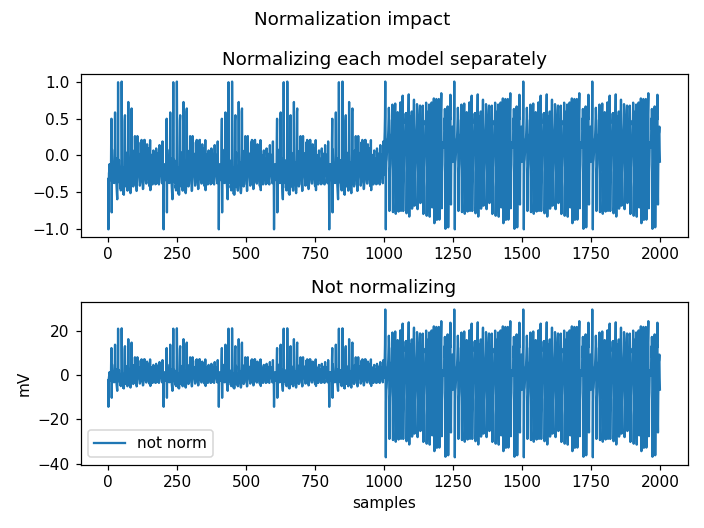

<IPython.core.display.Javascript object>


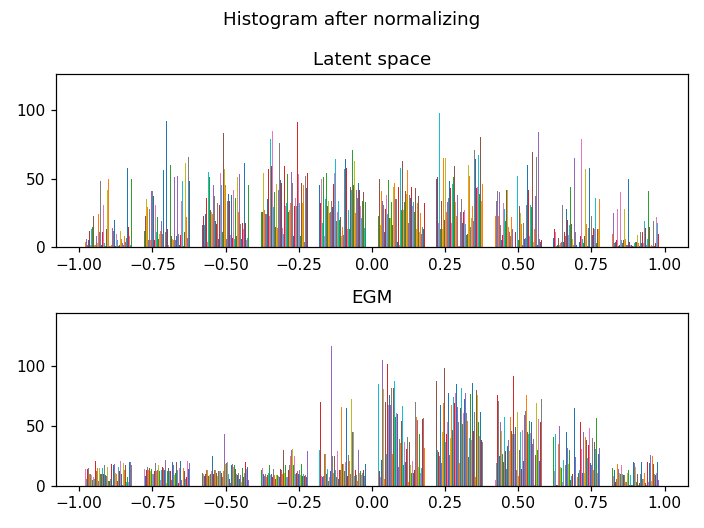

In [95]:

plt.figure(layout='tight')
plt.subplot(2, 1, 1)
#plt.plot(egm_tensor[:, 0], label='not norm')
plt.plot(egm_tensor_n[1000:3000, 0], label='norm')
plt.title('Normalizing each model separately')
plt.subplot(2, 1, 2)
plt.plot(egm_tensor[1000:3000, 0], label='not norm')
plt.xlabel('samples')
plt.ylabel('mV')
plt.title('Not normalizing')
plt.suptitle('Normalization impact')

plt.legend()
plt.show()

# HISTOGRAM AFTER NORM
plt.figure(layout='tight')
plt.subplot(2,1,1)
plt.hist(np.reshape(latent_space_norm, (latent_space_norm.shape[0], np.prod(latent_space_norm.shape[1:])) ))
plt.title('Latent space')
plt.subplot(2, 1, 2)
plt.hist(egm_tensor_norm)
plt.title('EGM')
plt.suptitle('Histogram after normalizing')


plt.show()

<IPython.core.display.Javascript object>


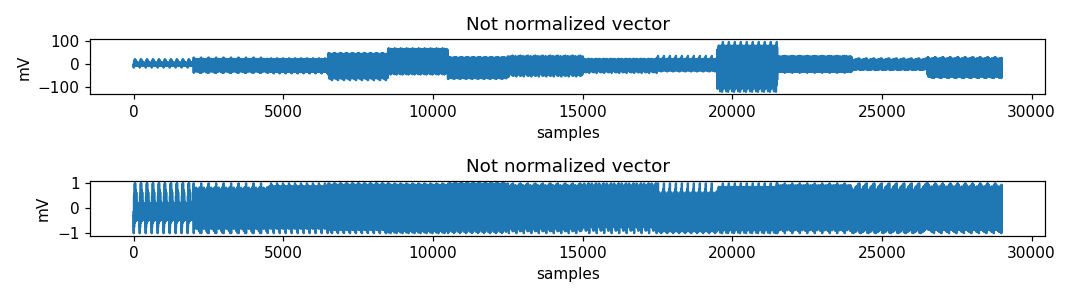

In [100]:
plt.figure(layout='tight')

plt.subplot(2, 1, 1)
plt.plot(egm_tensor[:, 0], label='not norm')
plt.xlabel('samples')
plt.ylabel('mV')
plt.title('Not normalized vector')
plt.subplot(2, 1, 2)
plt.plot(egm_tensor_n[:, 0], label='norm')
plt.xlabel('samples')
plt.ylabel('mV')
plt.title('Not normalized vector')
#plt.suptitle('Normalization impact')

#plt.legend()
plt.show()

In [36]:
y_train=egm_tensor_n[np.where((Y_model>=1) & (Y_model<=80))]
y_test=egm_tensor_n[np.where((Y_model>80) & (Y_model<=110))]
y_val=egm_tensor_n[np.where((Y_model>110) & (Y_model<=130))]

print(x_train.shape, x_test.shape, x_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)


if constellation:
    y_train=egm_tensor_resampled[np.where((Y_model>=1) & (Y_model<=80))]
    y_test=egm_tensor_resampled[np.where((Y_model>80) & (Y_model<=110))]
    y_val=egm_tensor_resampled[np.where((Y_model>110) & (Y_model<=130))]
    print(x_train.shape, x_test.shape, x_val.shape)
    print(y_train.shape, y_test.shape, y_val.shape)

(17500, 12, 32, 1) (6500, 12, 32) (5000, 12, 32, 1)
(17500, 2048) (6500, 2048) (5000, 2048)


#Normalization

norm= True

#if norm:
    #egm_tensor=egm_tensor_n

mm = np.mean(egm_tensor, axis=0)
ss = np.std(egm_tensor, axis=0)
egm_tensor = (egm_tensor - mm[np.newaxis, :]) / ss[np.newaxis, :]

#x_train
mm = np.mean(latent_vector_train, axis=0)
ss = np.std(latent_vector_train, axis=0)
latent_vector_train = (latent_vector_train - mm[np.newaxis, :, :, :]) / ss[np.newaxis, :, :, :]

#x_test
mm = np.mean(latent_vector_test, axis=0)
ss = np.std(latent_vector_test, axis=0)
latent_vector_test = (latent_vector_test - mm[np.newaxis, :, :, :]) / ss[np.newaxis, :, :, :]

#x_val
mm = np.mean(latent_vector_val, axis=0)
ss = np.std(latent_vector_val, axis=0)
latent_vector_val = (latent_vector_val - mm[np.newaxis, :, :, :]) / ss[np.newaxis, :, :, :]
latent_vector_val.shape


In [37]:
print('Latent vector train shape:', latent_vector_train.shape,'// Output EGM train shape:', y_train.shape)
print('Latent vector test shape:',latent_vector_test.shape, '// Output EGM test shape:', y_test.shape)
print('Latent vector val shape:',latent_vector_val.shape, '// Output EGM val shape:', y_val.shape)

Latent vector train shape: (17500, 3, 4, 12) // Output EGM train shape: (17500, 2048)
Latent vector test shape: (6500, 3, 4, 12) // Output EGM test shape: (6500, 2048)
Latent vector val shape: (5000, 3, 4, 12) // Output EGM val shape: (5000, 2048)


## Subsample nodes (originally 2040)

In [38]:
y_train_subsample = y_train[:, 0:2048:4]
y_test_subsample = y_test[:, 0:2048:4]
y_val_subsample = y_val[:, 0:2048:4]

print('Subsampled shape:',y_test_subsample.shape) 

Subsampled shape: (6500, 512)


# Training

In [39]:
from keras.layers import BatchNormalization

initializer = tf.keras.initializers.HeNormal()

estimator =models.Sequential()
estimator.add(layers.Conv2D(12, (4,4), strides=1, padding='same', activation='leaky_relu',
                            input_shape=latent_vector_train.shape[1:], kernel_initializer=initializer))
estimator.add(layers.UpSampling2D((2, 2)))
#estimator.add(BatchNormalization())
estimator.add(layers.Conv2D(12, (4,4), strides=1, padding='same', activation='leaky_relu'))
estimator.add(layers.Dropout(0.6))
estimator.add(layers.UpSampling2D((4 ,4)))
estimator.add(layers.Conv2D(6,(4,4), strides=1, padding='same', activation='relu'))
estimator.add(BatchNormalization())

#estimator.add(layers.UpSampling2D((4, 4)))
estimator.add(layers.Flatten())
estimator.add(layers.Dropout(0.6))
#estimator.add(layers.Dense(540, activation='relu'))
estimator.add(BatchNormalization())
#estimator.add(layers.Dropout(0.2))
#estimator.add(layers.Dense(505, activation='relu'))
#estimator.add(layers.Dropout(0.5))
estimator.add(layers.Dense(y_train_subsample.shape[1], activation='linear'))
#estimator.add(BatchNormalization())
estimator.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 3, 4, 12)          2316      
                                                                 
 up_sampling2d_6 (UpSampling  (None, 6, 8, 12)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 6, 8, 12)          2316      
                                                                 
 dropout_2 (Dropout)         (None, 6, 8, 12)          0         
                                                                 
 up_sampling2d_7 (UpSampling  (None, 24, 32, 12)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 32, 6)        

<IPython.core.display.Javascript object>


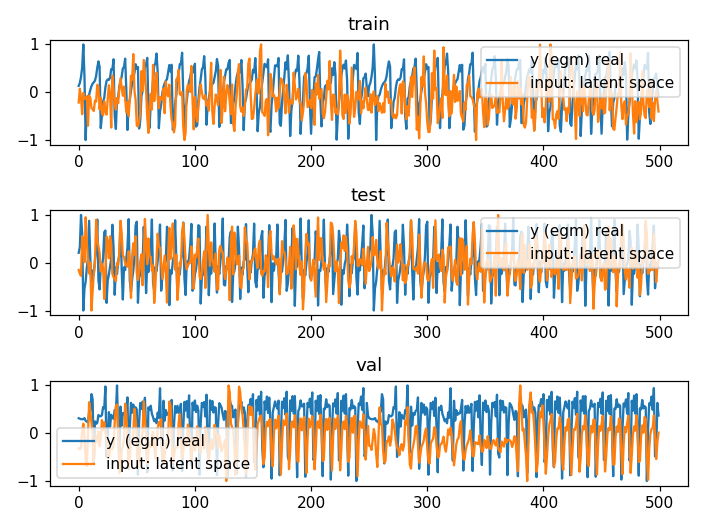

In [40]:

plt.figure(layout='tight')
plt.subplot(3, 1, 1)
plt.plot(y_train_subsample[4000:4500, 0], label='y (egm) real')
plt.plot(latent_vector_train[4000:4500, 0, 0, 0], label='input: latent space')
plt.title('train')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(y_test_subsample[4000:4500, 0], label='y (egm) real')
plt.plot(latent_vector_test[4000:4500, 0, 0, 0], label='input: latent space')
plt.title('test')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(y_val_subsample[4000:4500, 0], label='y  (egm) real')
plt.plot(latent_vector_val[4000:4500, 0, 0, 0], label='input: latent space')
plt.title('val')
plt.legend()
plt.show()


In [41]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=0.0001)


callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
estimator.compile(optimizer=optimizer, loss=losses.mean_squared_error)
history = estimator.fit(latent_vector_train, y_train_subsample, batch_size=50, epochs=200, validation_data=(latent_vector_val, y_val_subsample), callbacks=[callback])

/home/mgutierrez/anaconda3/envs/Research/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200
350/350 [==============================] - 5s 13ms/step - loss: 1.3878 - val_loss: 0.1743
Epoch 2/200
350/350 [==============================] - 4s 12ms/step - loss: 0.9074 - val_loss: 0.1625
Epoch 3/200
350/350 [==============================] - 4s 13ms/step - loss: 0.6962 - val_loss: 0.1603
Epoch 4/200
350/350 [==============================] - 4s 12ms/step - loss: 0.5510 - val_loss: 0.1574
Epoch 5/200
350/350 [==============================] - 4s 13ms/step - loss: 0.4435 - val_loss: 0.1558
Epoch 6/200
350/350 [==============================] - 4s 12ms/step - loss: 0.3633 - val_loss: 0.1574
Epoch 7/200
350/350 [==============================] - 4s 13ms/step - loss: 0.3033 - val_loss: 0.1584
Epoch 8/200
350/350 [==============================] - 5s 14ms/step - loss: 0.2583 - val_loss: 0.1593
Epoch 9/200
350/350 [==============================] - 5s 13ms/step - loss: 0.2248 - val_loss: 0.1612
Epoch 10/200
350/350 [==============================] - 5s 13ms/step - loss: 0.200

350/350 [==============================] - 5s 14ms/step - loss: 0.1247 - val_loss: 0.1619
Epoch 81/200
350/350 [==============================] - 5s 14ms/step - loss: 0.1247 - val_loss: 0.1610
Epoch 82/200
350/350 [==============================] - 5s 14ms/step - loss: 0.1245 - val_loss: 0.1608
Epoch 83/200
350/350 [==============================] - 5s 14ms/step - loss: 0.1243 - val_loss: 0.1622
Epoch 84/200
350/350 [==============================] - 5s 14ms/step - loss: 0.1242 - val_loss: 0.1601
Epoch 85/200
350/350 [==============================] - 5s 14ms/step - loss: 0.1237 - val_loss: 0.1610
Epoch 86/200
350/350 [==============================] - 5s 14ms/step - loss: 0.1237 - val_loss: 0.1623
Epoch 87/200
350/350 [==============================] - 5s 14ms/step - loss: 0.1234 - val_loss: 0.1605
Epoch 88/200
350/350 [==============================] - 5s 14ms/step - loss: 0.1233 - val_loss: 0.1625
Epoch 89/200
350/350 [==============================] - 5s 14ms/step - loss: 0.1233 - 

<IPython.core.display.Javascript object>


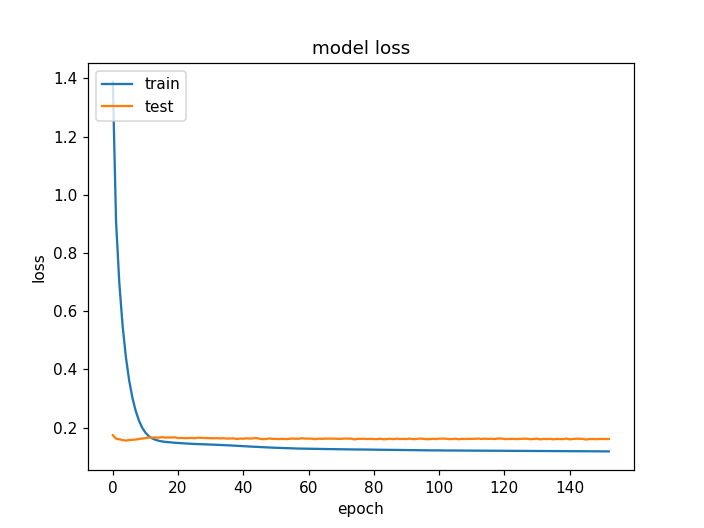

In [42]:
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [111]:
estimate_egms_test = estimator.predict(latent_vector_test)
estimate_egms_train = estimator.predict(latent_vector_train)

from sklearn.metrics import mean_squared_error
print('MAE Train:', mean_squared_error(y_train_subsample, estimate_egms_train)) # train
print('MAE Test:',mean_squared_error(y_test_subsample, estimate_egms_test)) # test


MAE Train: 0.1034312815916447
MAE Test: 0.18523689722367087


# PROCESS RECONSTRUCTION

## Plot random 50 samples signal (Estimated EGM vs original BSPS signal vs Latent space)

<IPython.core.display.Javascript object>


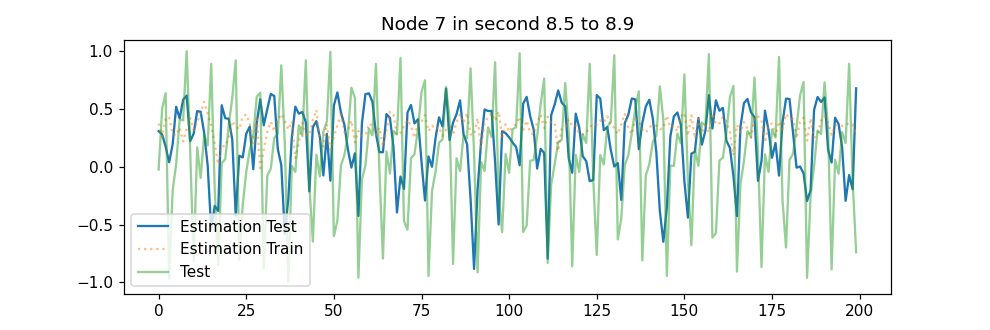

In [141]:
interv=random.randrange(0, len(estimate_egms_test)-1, 50)
node=random.randrange(0, 512, 1)
normalize_ = True 
#normalize between -1 and 1

if normalize_ == True:

    #Normalize
    y_test_subsample_norm=normalize_array(y_test_subsample, 1, -1, 0)
    estimate_egms_norm=normalize_array(estimate_egms_test, 1, -1, 0)
    #estimate_egms_train_norm = normalize_array (estimate_egms_train, np.max(y_test_subsample), np.min(y_test_subsample)) 
    #estimate_egms_test_norm = normalize_array (estimate_egms_test, np.max(y_test_subsample), np.min(y_test_subsample))
else:   
    #Normalize
    y_test_subsample_norm=standardize_array(y_test_subsample)
    estimate_egms_norm=standardize_array(estimate_egms_test)
    #estimate_egms_train_norm = standardize_array (estimate_egms_train)
    #estimate_egms_test_norm = standardize_array (estimate_egms_test)
   
plt.figure(figsize=(9, 3))
plt.plot(estimate_egms_norm[interv: interv+200 ,node], label='Estimation Test')
plt.plot(estimate_egms_train_norm[interv: interv+200,node],':', alpha=0.5, label='Estimation Train')
plt.plot(y_test_subsample[interv:interv+200, node], label= 'Test', alpha=0.5)
#plt.plot(latent_vector_test[200:400, 0, 0, 0], label = 'Latent Vector')
text='Node {} in second {} to {}'.format(node, interv/fs, interv/fs +200/fs)
plt.legend()
plt.title(text)
plt.show()

<IPython.core.display.Javascript object>


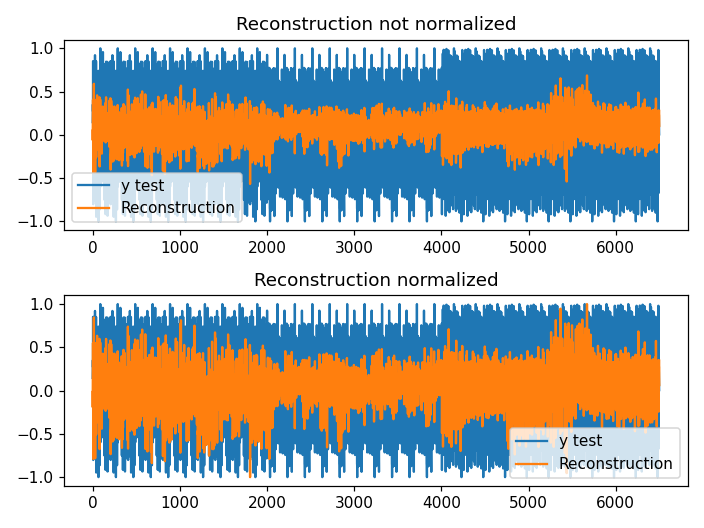

Text(0.5, 1.0, 'Reconstruction normalized')

In [156]:
plt.figure(layout='tight')
plt.subplot(2, 1, 1)

plt.plot(y_test_subsample[:, 500], label='y test')
plt.plot(estimate_egms_test[:, 500], label='Reconstruction')
plt.title('Reconstruction not normalized')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(y_test_subsample_norm[:, 500], label='y test')
plt.plot(estimate_egms_norm[:, 500], label='Reconstruction')
plt.legend()
plt.title('Reconstruction normalized')



<IPython.core.display.Javascript object>


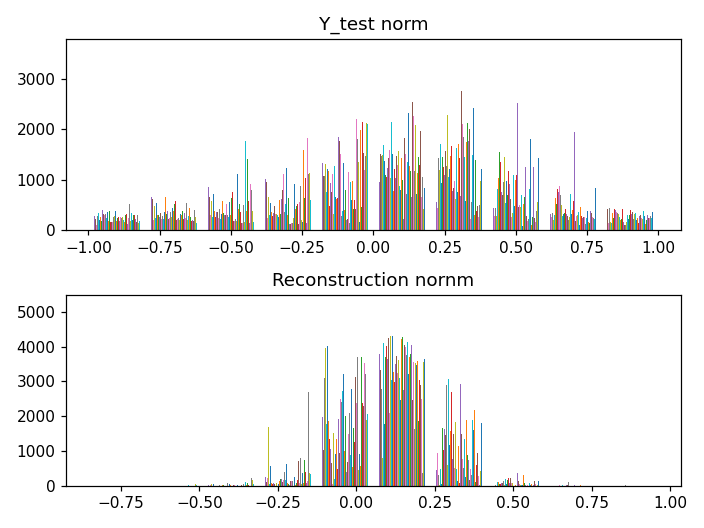

In [116]:
plt.figure( layout='tight')
plt.subplot(2,1,1)
plt.hist(y_test_subsample)
plt.title('Y_test norm')
plt.subplot(2, 1, 2)
plt.hist(estimate_egms_test)
plt.title('Reconstruction nornm')

plt.show()

<IPython.core.display.Javascript object>


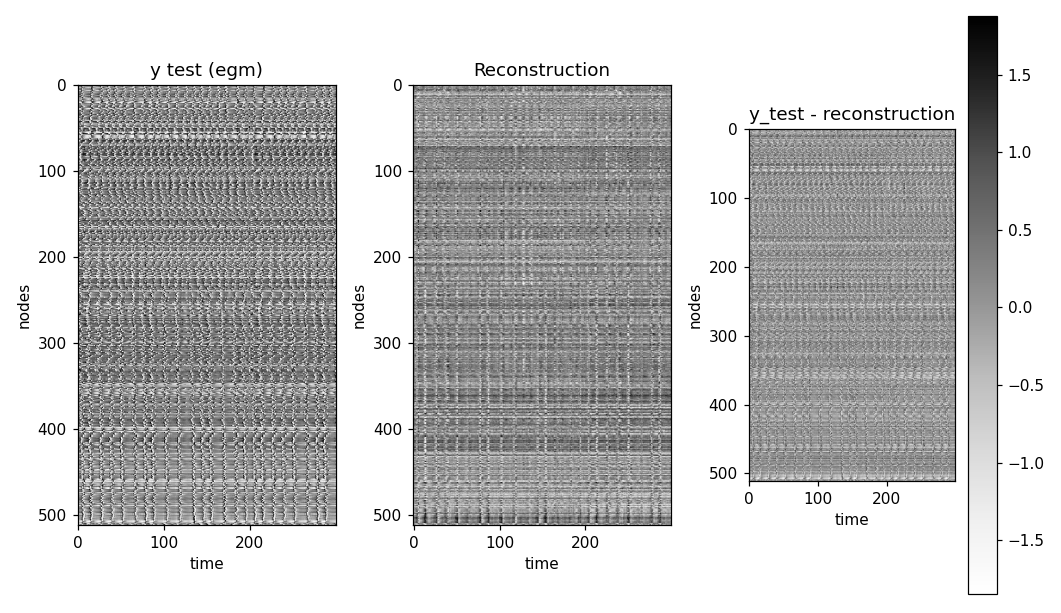

In [152]:


plt.figure(layout='tight')
plt.subplot(1, 3, 1)
plt.imshow(y_test_subsample_norm[0:300, :].T, cmap='Greys')
plt.title('y test (egm)')
plt.xlabel('time')
plt.ylabel('nodes')
plt.subplot(1, 3, 2)
plt.imshow(estimate_egms_norm[0:300, :].T, cmap='Greys')
plt.title('Reconstruction')
plt.xlabel('time')
plt.ylabel('nodes')
plt.subplot(1, 3, 3)
plt.imshow(y_test_subsample_norm[0:300, :].T-estimate_egms_norm[0:300, :].T, cmap='Greys')
plt.title('y_test - reconstruction')
plt.xlabel('time')
plt.ylabel('nodes')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


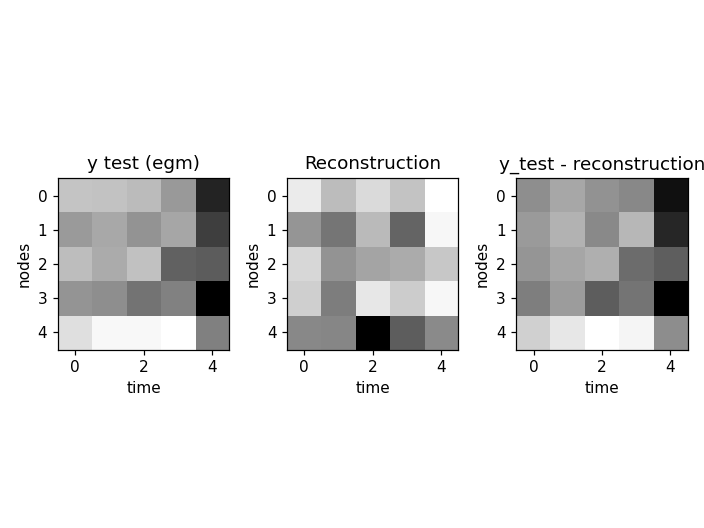

In [151]:

plt.figure(layout='tight')
plt.subplot(1, 3, 1)
plt.imshow(y_test_subsample_norm[0:5,0:5 ].T, cmap='Greys')
plt.title('y test (egm)')
plt.xlabel('time')
plt.ylabel('nodes')
plt.subplot(1, 3, 2)
plt.imshow(estimate_egms_norm[0:5, 0:5].T, cmap='Greys')
plt.title('Reconstruction')
plt.xlabel('time')
plt.ylabel('nodes')
plt.subplot(1, 3, 3)
plt.imshow(y_test_subsample_norm[0:5, 0:5].T-estimate_egms_norm[0:5, 0:5].T, cmap='Greys')
plt.title('y_test - reconstruction')
plt.xlabel('time')
plt.ylabel('nodes')
plt.show()

In [ ]:
LS_signal= latent_vector_test
output_signal= estimate_egms_test
nperseg_value=200

fig=plt.figure(layout='tight')

plt.subplot(2,1,1)

#Input
for height in range(0,511, 5):
    
    f, Pxx_den = signal.welch(output_signal[:, height], 50, nperseg=nperseg_value)
    plt.semilogy(f, Pxx_den)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    titlee="PSD Welch of EGM signal estimation. node {}".format(height )
    plt.title('EGM signals')
    plt.show()


# Latent Space
plt.subplot(2,1,2)
for height in range(0,3):
    for width in range(0,4):
        for filters in range(0,12,2):
    
            f, Pxx_den = signal.welch(LS_signal[:, height,width, filters], 50, nperseg=nperseg_value)
            plt.semilogy(f, Pxx_den)
            plt.xlabel('frequency [Hz]')
            plt.ylabel('PSD [V**2/Hz]')
            titlee="PSD Welch of Latent Space signal. nodes ( - )".format(height,width )
            plt.title('latent Space')
            plt.show()
fig.suptitle("Segment length= 200", fontsize=15)

